Episode 0, Total Reward: 18.0
Episode 10, Total Reward: 52.0
Episode 20, Total Reward: 14.0


/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_91040/2611796883.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 30, Total Reward: 13.0
Episode 40, Total Reward: 13.0
Episode 50, Total Reward: 16.0
Episode 60, Total Reward: 13.0
Episode 70, Total Reward: 16.0
Episode 80, Total Reward: 18.0
Episode 90, Total Reward: 42.0
Episode 100, Total Reward: 44.0
Episode 110, Total Reward: 15.0
Episode 120, Total Reward: 20.0
Episode 130, Total Reward: 77.0
Episode 140, Total Reward: 67.0
Episode 150, Total Reward: 64.0
Episode 160, Total Reward: 21.0
Episode 170, Total Reward: 266.0
Episode 180, Total Reward: 165.0
Episode 190, Total Reward: 134.0
Episode 200, Total Reward: 161.0
Episode 210, Total Reward: 223.0
Episode 220, Total Reward: 249.0
Episode 230, Total Reward: 232.0
Episode 240, Total Reward: 500.0
Episode 250, Total Reward: 500.0
Episode 260, Total Reward: 500.0
Early stopping at episode 268, average reward: 477.5


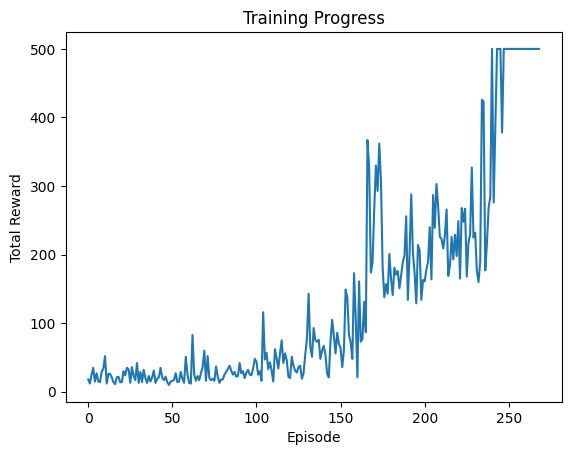

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

MAX_MEMORY = 500
NUM_NEURONS = 64
LR_CRITIC = 0.0005
LR_ACTOR = 0.001
GAMMA = 0.99
LAMBDA = 0.95
CLIP_EPS = 0.2
K_EPOCH = 10
EARLY_STOP_THRESHOLD = 470

def compute_advantages(rewards, values, dones, gamma=GAMMA, lam=LAMBDA):
    advantages = []
    gae = 0
    values = values + [0]  # Append a 0 for the last state
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    return torch.tensor(advantages, dtype=torch.float)

class PolicyNet(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, num_actions)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)

class ValueNet(nn.Module):
    def __init__(self, num_inputs):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class PPOAgent(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PPOAgent, self).__init__()
        self.actor = PolicyNet(num_inputs, num_actions)
        self.critic = ValueNet(num_inputs)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.buffer = []
    
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.actor(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def store_transition(self, transition):
        self.buffer.append(transition)
    
    def update(self):
        states, actions, rewards, dones, old_log_probs = zip(*self.buffer)
        old_log_probs = torch.stack(old_log_probs)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        values = self.critic(states).squeeze()
        advantages = compute_advantages(rewards.tolist(), values.tolist(), dones.tolist())
        #advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-6)
        
        for _ in range(K_EPOCH):
            new_log_probs = torch.stack([Categorical(self.actor(state)).log_prob(action) for state, action in zip(states, actions)])
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = F.mse_loss(self.critic(states).squeeze(), rewards)
            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            policy_loss.backward()
            value_loss.backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()
        
        self.buffer.clear()

def train_ppo(env_name='CartPole-v1', num_episodes=1000):
    env = gym.make(env_name)
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.n
    agent = PPOAgent(num_inputs, num_actions)
    reward_history = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        early_stop = False
        
        while not done:
            action, log_prob = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.store_transition((state, action, reward, done, log_prob))
            state = next_state
            total_reward += reward

        reward_history.append(total_reward)
        
        if len(reward_history) >= 50 and np.mean(reward_history[-30:]) > EARLY_STOP_THRESHOLD:
            print(f"Early stopping at episode {episode}, average reward: {np.mean(reward_history[-30:])}")
            early_stop = True
            break
        
        if early_stop:
            break

        if len(agent.buffer) >= MAX_MEMORY:
            agent.update()
        
        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")
    
    env.close()

    plt.plot(reward_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()


    return agent

if __name__ == "__main__":
    trained_agent = train_ppo()


GIF saved at cartpole_ppo_test.gif


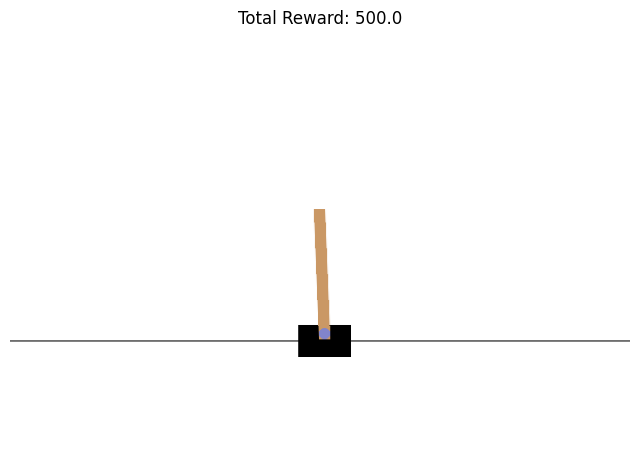

500.0

In [2]:
import gymnasium as gym
import torch
import imageio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def test_and_generate_gif(agent, env_name='CartPole-v1', gif_path='cartpole_ppo_test.gif'):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    frames = []
    total_reward = 0
    done = False
    
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32)
        probs = agent.actor(state_tensor)
        action = torch.argmax(probs).item()
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated
        frames.append(Image.fromarray(env.render()))
    
    env.close()
    
    # Save GIF
    frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=50, loop=0)
    print(f"GIF saved at {gif_path}")
    
    # Display GIF
    plt.figure(figsize=(8, 6))
    plt.imshow(np.array(frames[0]))
    plt.axis('off')
    plt.title(f'Total Reward: {total_reward}')
    plt.show()
    
    return total_reward

# Example usage (assuming trained_agent is available):
test_and_generate_gif(trained_agent)
